This model is a [ResNet152](https://huggingface.co/microsoft/resnet-152) model trained on 224x224 resolution data from ImageNet-1k run with unfrozen parameters. 

# Loading in Data

Import Packages

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import huggingface_hub
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os

Load in the training data from huggingface

In [2]:
from datasets import load_dataset, DatasetDict, Dataset

dataset = load_dataset('saking3/alaska_dead_trees')

/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})

Subsetting the dataset so the training dataset only contains 5000 randomly selected training images. 

In [4]:
training_size = 5000 #10, 100, 500, 1000, 5000

random_indices = np.random.choice(len(dataset["train"]), size=training_size, replace=False)

In [5]:
# Select the random subset
train_subset = dataset["train"].select(random_indices)

# Create a new DatasetDict with the subset
subset_training_dataset = DatasetDict({
    "train": train_subset,
    "validation": dataset["validation"],
    "test": dataset["test"]
})

# Print the structure of the new subset dataset to confirm
print(subset_training_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})


Let's load the mappings between integers and their classes 

In [6]:
#get labels for each dataset 
id2label = {0: 'Background', 1: 'Dead Tree'}

Create a 'dataset' that serves us input images and masks in a format appropriate for the ResNet model.

In [39]:
class ForestDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        mask = self.dataset[idx]['label']

        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
    
        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(np.array(mask), dtype=torch.float).unsqueeze(0)
        return image, mask

## Transformations 
We augment the training images by resizing them to a fixed resolution (448x448), converting the images to tensors, and normalizing the color channels.

In [40]:
train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Create the training, validation, and test dataset and check the length of each dataset.

In [41]:
train_dataset = ForestDataset(subset_training_dataset['train'], transform=train_transform)
val_dataset = ForestDataset(subset_training_dataset['validation'], transform=val_transform)
test_dataset = ForestDataset(subset_training_dataset['test'], transform=val_transform)

In [42]:
print("Number of train images:", len(train_dataset))
print("Number of val images:", len(val_dataset))
print("Number of test images:", len(test_dataset))

Number of train images: 5000
Number of val images: 653
Number of test images: 1286


Create the training, validation, and test dataloaders to feed data to the model. 

In [43]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Training the Model

## Model Structure

**ResNet-152 Backbone:** ResNet-152 is a deep residual network with 152 layers, pre-trained on the ImageNet dataset.

**Feature Extraction:** The model uses a forward hook to capture the output of the layer4[0] block of ResNet-152, which contains high-level features. This is where the deep features of the input image are extracted.

**Upsampling Layers:** After extracting features, the model uses a series of transposed convolutional layers to upsample the feature maps to the original image size.
        Transposed Convolution Layers (ConvTranspose2d):
            upconv1: Upsamples the 2048 feature maps from layer4 to 1024 channels.
            upconv2: Upsamples from 1024 channels to 512 channels.
            upconv3: Upsamples from 512 channels to 256 channels.
            upconv4: Upsamples from 256 channels to the number of output classes.

**Final Upsampling:** After the transposed convolutional layers, a final bilinear upsampling layer (Upsample) resizes the output to a target size of 256x256 pixels. This ensures that the segmentation mask matches the desired output resolution.

## The Forward Pass

**Initial Convolution and Pooling:** The input image is passed through the initial layers of ResNet-152 (conv1, bn1, relu, maxpool) to extract basic features.

**Residual Layers:** The image is processed through four residual layers (layer1 to layer4) in ResNet-152. The features are gradually refined and reduced in spatial dimensions while increasing in depth (number of channels).

**Upsampling:** After extracting the features from the last residual layer (layer4), the transposed convolutional layers progressively upsample these features back to the original spatial resolution. Each upsampling step reduces the depth (number of channels) of the feature maps while increasing their spatial dimensions.

**Final Output:** The final output is a segmentation mask with dimensions [batch_size, num_classes, 256, 256]. For a binary segmentation task, num_classes would typically be 1, meaning the output is a single-channel mask where each pixel represents the probability of belonging to the target class (e.g., a specific object or region in the image).

In [35]:
#define resnet model
class ResNet152Segmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet152Segmentation, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
        
        # Extract the features from the ResNet model
        self.resnet.layer4[0].register_forward_hook(self.hook_fn)
        
        # Define the upsampling layers
        self.upconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(256, num_classes, kernel_size=4, stride=2, padding=1)

        # Upsample to match the target size (256x256)
        self.final_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)

    def hook_fn(self, module, input, output):
        self.features = output

    def forward(self, x):
        x = self.resnet.conv1(x)   # Initial conv layer
        x = self.resnet.bn1(x)     # Initial batch norm
        x = self.resnet.relu(x)    # Initial ReLU
        x = self.resnet.maxpool(x) # Initial max pooling
        
        x = self.resnet.layer1(x)  # First ResNet layer block
        x = self.resnet.layer2(x)  # Second ResNet layer block
        x = self.resnet.layer3(x)  # Third ResNet layer block
        x = self.resnet.layer4(x)  # Fourth ResNet layer block

        # Apply upsampling
        x = self.upconv1(x)        # Upsample to [batch, 1024, 56, 56]
        x = self.upconv2(x)        # Upsample to [batch, 512, 112, 112]
        x = self.upconv3(x)        # Upsample to [batch, 256, 224, 224]
        x = self.upconv4(x)        # Upsample to [batch, num_classes, 448, 448]
        x = self.final_upsample(x) # Resize to [batch, num_classes, 256, 256]
        
        return x

We can instantiate the model as follows:

In [29]:
model = ResNet152Segmentation(num_classes=1)

# Ensure all parameters are trainable/unfrozen
for param in model.parameters():
    param.requires_grad = True

Pick loss function and gradient descent method (Adam function). 

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

Train the model. It's set to print stats per epoch. 

In [33]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Wrap the data loader with tqdm to show the progress bar
        for images, masks in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # Ensure the outputs and targets are the same size
            if outputs.size() != masks.size():
                outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [34]:
train_model(model, train_loader, criterion, optimizer, num_epochs=30)

Epoch 1/30:   0%|          | 0/1250 [00:00<?, ?batch/s]/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1/30: 100%|██████████| 1250/1250 [05:48<00:00,  3.59batch/s]


Epoch 1/30, Loss: 0.2826


Epoch 2/30: 100%|██████████| 1250/1250 [04:49<00:00,  4.32batch/s]


Epoch 2/30, Loss: 0.2194


Epoch 3/30: 100%|██████████| 1250/1250 [04:50<00:00,  4.30batch/s]


Epoch 3/30, Loss: 0.1984


Epoch 4/30: 100%|██████████| 1250/1250 [04:57<00:00,  4.20batch/s]


Epoch 4/30, Loss: 0.1777


Epoch 5/30: 100%|██████████| 1250/1250 [04:49<00:00,  4.31batch/s]


Epoch 5/30, Loss: 0.1572


Epoch 6/30: 100%|██████████| 1250/1250 [04:56<00:00,  4.22batch/s]


Epoch 6/30, Loss: 0.1402


Epoch 7/30: 100%|██████████| 1250/1250 [04:51<00:00,  4.28batch/s]


Epoch 7/30, Loss: 0.1269


Epoch 8/30: 100%|██████████| 1250/1250 [04:50<00:00,  4.30batch/s]


Epoch 8/30, Loss: 0.1175


Epoch 9/30: 100%|██████████| 1250/1250 [04:56<00:00,  4.21batch/s]


Epoch 9/30, Loss: 0.1109


Epoch 10/30: 100%|██████████| 1250/1250 [04:54<00:00,  4.25batch/s]


Epoch 10/30, Loss: 0.1067


Epoch 11/30: 100%|██████████| 1250/1250 [04:54<00:00,  4.24batch/s]


Epoch 11/30, Loss: 0.1035


Epoch 12/30: 100%|██████████| 1250/1250 [04:55<00:00,  4.22batch/s]


Epoch 12/30, Loss: 0.1009


Epoch 13/30: 100%|██████████| 1250/1250 [04:56<00:00,  4.22batch/s]


Epoch 13/30, Loss: 0.0985


Epoch 14/30: 100%|██████████| 1250/1250 [04:56<00:00,  4.22batch/s]


Epoch 14/30, Loss: 0.0967


Epoch 15/30: 100%|██████████| 1250/1250 [04:56<00:00,  4.21batch/s]


Epoch 15/30, Loss: 0.0952


Epoch 16/30: 100%|██████████| 1250/1250 [04:54<00:00,  4.24batch/s]


Epoch 16/30, Loss: 0.0938


Epoch 17/30:  18%|█▊        | 223/1250 [00:54<06:11,  2.77batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 21/30: 100%|██████████| 1250/1250 [04:53<00:00,  4.26batch/s]


Epoch 21/30, Loss: 0.0879


Epoch 22/30: 100%|██████████| 1250/1250 [04:48<00:00,  4.33batch/s]


Epoch 22/30, Loss: 0.0869


Epoch 23/30: 100%|██████████| 1250/1250 [04:46<00:00,  4.37batch/s]


Epoch 23/30, Loss: 0.0863


Epoch 24/30: 100%|██████████| 1250/1250 [04:44<00:00,  4.40batch/s]


Epoch 24/30, Loss: 0.0854


Epoch 25/30: 100%|██████████| 1250/1250 [04:46<00:00,  4.36batch/s]


Epoch 25/30, Loss: 0.0842


Epoch 26/30: 100%|██████████| 1250/1250 [04:46<00:00,  4.37batch/s]


Epoch 26/30, Loss: 0.0838


Epoch 27/30: 100%|██████████| 1250/1250 [04:51<00:00,  4.28batch/s]


Epoch 27/30, Loss: 0.0834


Epoch 28/30: 100%|██████████| 1250/1250 [04:48<00:00,  4.34batch/s]


Epoch 28/30, Loss: 0.0824


Epoch 29/30: 100%|██████████| 1250/1250 [04:46<00:00,  4.36batch/s]


Epoch 29/30, Loss: 0.0816


Epoch 30/30: 100%|██████████| 1250/1250 [04:41<00:00,  4.44batch/s]

Epoch 30/30, Loss: 0.0812


In [95]:
Save the trained model so it can be used to run predictions.

SyntaxError: invalid syntax (2484595688.py, line 1)

In [36]:
# Save the model's state dictionary
torch.save(model.state_dict(), '/explore/nobackup/people/sking11/resnet152_model_checkpoint.pth')

# Save the entire model
torch.save(model, '/explore/nobackup/people/sking11/resnet152_model.pth')

# Performing Inference on single tile for dataset

Let's first load in the model

In [13]:
# Load the entire model
model = torch.load('/explore/nobackup/people/sking11/resnet152_model.pth')
model.eval()

/tmp/ipykernel_1367914/3087834380.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/explore/nobackup/people/sking11/resnet152_model.pth')


ResNet152Segmentation(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

then set the device we want to run the model on 

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we load in an image, convert the image to a tensor, ensure the values are in the correct order, and check the shape of the validation image and converted tensor.

In [96]:
# Extract the image from the dataset
val_image, _ = val_dataset[300]  # Change index as needed

# Check the shape of val_image
print(val_image.shape)  # Should be [height, width, num_channels]

# Convert to tensor and permute to [num_channels, height, width]
pixel_values = torch.tensor(val_image).permute(0, 1, 2)  

# Add the batch dimension
pixel_values = pixel_values.unsqueeze(0)  # Final shape should be [1, 3, 448, 448]

# Verify the shape
print(pixel_values.shape)  # Should be [1, 3, 448, 448]

torch.Size([3, 448, 448])
torch.Size([1, 3, 448, 448])


/tmp/ipykernel_1367914/4093021473.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(val_image).permute(0, 1, 2)


Run and plot the probability mask and the predicted mask generated by our model predictions. 

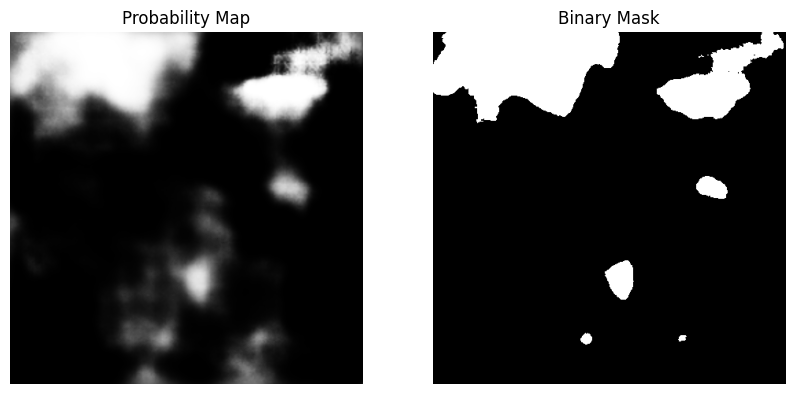

In [89]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    outputs = model(pixel_values.to(device))  # Forward pass through the model

# Upsample the output to match the original image size, if necessary
upsampled_logits = torch.nn.functional.interpolate(outputs,
                                                   size=(448, 448),
                                                   mode='bilinear', align_corners=False)

# Convert the logits to probabilities
predicted_probabilities = torch.sigmoid(upsampled_logits).squeeze().cpu().numpy()

# Convert probabilities to binary mask
predicted_binary_mask = (predicted_probabilities > 0.5).astype(np.uint8)

# Plot both the probability map and the binary mask side-by-side
plt.figure(figsize=(10, 5))

# Plot the probability map
plt.subplot(1, 2, 1)
plt.imshow(predicted_probabilities, cmap='gray')
plt.title('Probability Map')
plt.axis('off')

# Plot the binary mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()

Save the binary mask as an image with PIL. 

In [93]:
binary_mask_image = Image.fromarray(predicted_binary_mask * 255)  # Scale binary mask to 0-255
binary_mask_image.save('/explore/nobackup/people/sking11/saved_figures/predictedmaskRESNET152_5000.png')

# Running Model Statistics using our evaluation dataset

In order to run model statistics, we need to first get predictions for a validation/test dataset of images. The following block will run model predictions on an entire set of images and save them to a numpy list.

In [64]:
model.eval()  # Set the model to evaluation mode
predicted_arrays = []  # List to store the predicted arrays

with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(val_loader, desc="Running predictions")):
        images = images.to(device)
        outputs = model(images)
        
        # Iterate through each image in the batch
        for j in range(outputs.size(0)):
            predicted_map = outputs[j].squeeze(0)  # Assuming it's a single-channel output
            predicted_map_np = predicted_map.cpu().numpy()
            
            # Apply threshold to convert to binary
            predicted_map_np = (predicted_map_np > 0.5).astype(np.uint8)
            
            # Optionally, convert to 8-bit integers if needed
            # predicted_map_np = (predicted_map_np * 255).astype(np.uint8)
            
            # Save the numpy array to the list
            predicted_arrays.append(predicted_map_np)

Running predictions: 100%|██████████| 164/164 [00:19<00:00,  8.28it/s]


We grab the validation masks from the validation dataset and also save those in a numpy array so that they can be compared to the predicted masks. 

In [69]:
val_masks_list = []

# Iterate over the validation dataset
for idx in tqdm(range(len(val_dataset)), desc="Processing validation masks"):
    _, mask = val_dataset[idx]  # Get the mask from the dataset
    
    # Convert mask tensor to NumPy array
    mask_np = mask.squeeze(0).cpu().numpy()  # Remove channel dimension and move to CPU if necessary
    
    # Ensure mask values are binary (0 or 1)
    mask_np = (mask_np > 0.5).astype(np.uint8)
    
    # Append to the list
    val_masks_list.append(mask_np)

Processing validation masks: 100%|██████████| 653/653 [00:08<00:00, 78.79it/s] 


Calculate the total pixel accuracy fraction across the whole dataset. 

In [97]:
accuracies = []

# Loop through each pair of predicted and original masks
for predicted_mask, original_mask in zip(predicted_arrays, val_masks_list):
    # Ensure both masks have the same shape
    assert predicted_mask.shape == original_mask.shape, "Shape mismatch between predicted and original masks"
    
    # Calculate the accuracy for the current pair of masks
    accuracy = np.mean(predicted_mask == original_mask)
    accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)
average_accuracy = np.average(accuracies)

print(f'Average Accuracy: {average_accuracy}')

Average Accuracy: 0.9009011518352795


Calculate the mean IoU across the whole dataset. 

In [86]:
import numpy as np

def calculate_iou(predicted_mask, actual_mask):
    # Ensure the masks are binary (0 and 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    actual_mask = (actual_mask > 0.5).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, actual_mask)
    union = np.logical_or(predicted_mask, actual_mask)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(predicted_masks, actual_masks):
    ious = []

    for pred, actual in zip(predicted_masks, actual_masks):
        iou = calculate_iou(pred, actual)
        ious.append(iou)

    mean_iou = np.mean(ious)
    return mean_iou

mean_iou = calculate_mean_iou(predicted_arrays, val_masks_list)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.3448


Calculate the confusion matrix across the whole dataset. 

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Flatten all masks and concatenate them into single arrays
actual_flat = np.concatenate([mask.flatten() for mask in val_masks_list])
predicted_flat = np.concatenate([mask.flatten() for mask in predicted_arrays])

# Ensure only two classes: 0 and 1
assert np.all(np.isin(actual_flat, [0, 1])), "Actual masks contain values other than 0 and 1"
assert np.all(np.isin(predicted_flat, [0, 1])), "Predicted masks contain values other than 0 and 1"

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_flat, predicted_flat, labels=[0, 1])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[36049507  3833160]
 [  407776  2504565]]


Calculate the accuracy per tile. This can be plotted to view and understand the variation in accuracy across the whole dataset.

In [90]:
# Calculate accuracy for each tile
accuracies = []
for actual_mask, predicted_mask in zip(val_masks_list, predicted_arrays):
    # Ensure both masks have the same shape
    assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask shapes"
    
    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(actual_mask == predicted_mask)
    total_pixels = actual_mask.size
    accuracy = correct_pixels / total_pixels
    
    accuracies.append(accuracy)

# Now, accuracies contains the accuracy for each tile
for idx, acc in enumerate(accuracies):
    print(f"Tile {idx}: Accuracy = {acc:.4f}")

Tile 0: Accuracy = 0.3957
Tile 1: Accuracy = 0.3760
Tile 2: Accuracy = 0.5829
Tile 3: Accuracy = 0.6091
Tile 4: Accuracy = 0.5621
Tile 5: Accuracy = 0.8754
Tile 6: Accuracy = 0.8844
Tile 7: Accuracy = 0.6137
Tile 8: Accuracy = 0.5624
Tile 9: Accuracy = 0.6030
Tile 10: Accuracy = 0.6999
Tile 11: Accuracy = 0.6074
Tile 12: Accuracy = 0.5863
Tile 13: Accuracy = 0.6325
Tile 14: Accuracy = 0.6248
Tile 15: Accuracy = 0.5807
Tile 16: Accuracy = 0.3630
Tile 17: Accuracy = 0.4167
Tile 18: Accuracy = 0.4820
Tile 19: Accuracy = 0.4986
Tile 20: Accuracy = 0.5085
Tile 21: Accuracy = 0.7452
Tile 22: Accuracy = 0.7459
Tile 23: Accuracy = 0.8200
Tile 24: Accuracy = 0.8766
Tile 25: Accuracy = 0.8423
Tile 26: Accuracy = 0.8889
Tile 27: Accuracy = 0.6718
Tile 28: Accuracy = 0.9296
Tile 29: Accuracy = 0.8749
Tile 30: Accuracy = 0.8194
Tile 31: Accuracy = 0.9594
Tile 32: Accuracy = 0.9706
Tile 33: Accuracy = 0.8761
Tile 34: Accuracy = 0.9639
Tile 35: Accuracy = 0.9836
Tile 36: Accuracy = 0.9257
Tile 37: Ac

Save the accuracies into a CSV for later use. 

In [91]:
import csv

# Specify the full file path
file_path = '/explore/nobackup/people/sking11/accuracies/RESNET152_5000_accuracies.csv'

# Save as CSV using csv module
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Tile', 'Accuracy'])  # Write the header
    for idx, accuracy in enumerate(accuracies):
        writer.writerow([idx, accuracy])

Plot the variation in accuracy. 

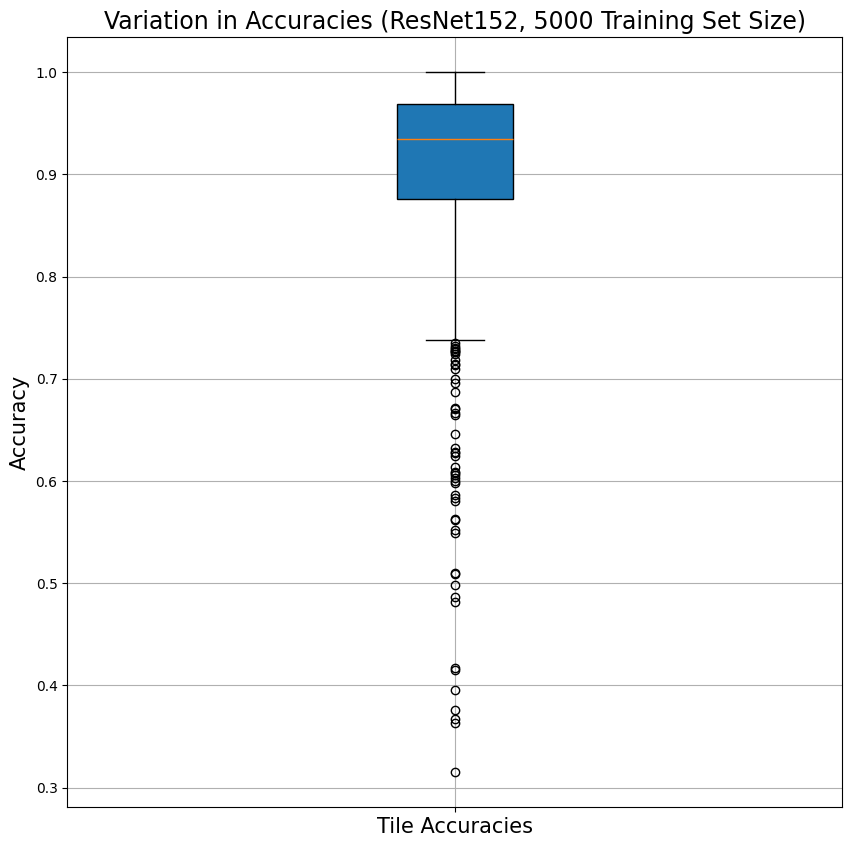

In [94]:
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 10))
plt.boxplot(accuracies, vert=True, patch_artist=True)

# Adding titles and labels with customized font sizes
plt.title('Variation in Accuracies (ResNet152, 5000 Training Set Size)', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)

# Optional: Customize the plot
plt.xticks([1], ['Tile Accuracies'], fontsize=15)  # Since there's only one box plot
plt.grid(True)

# Display the plot
plt.show()